loan_df : Features:
https://www.kaggle.com/datasets/nikhil1e9/loan-default

loan_id: A unique identifier for each loan

Age: The age of the borrower

income: The annual income of the borrower

loan_amount: Total amount of the loan

Credit_score: The credit score of the borrower

months_employed: The number of months the borrower has been employed

Num_credit_lines: The number of credit lines the borrower has open

Interest_rate: The interest rate for the loan

Loan_term: The term length of the loan in months

DTIratio: The Debt-to-Income ratio
 
 Education:
 
employment_status: Employment status (Employed / Unemployed)

default: Whether the loan was defaulted (1 = Yes, 0 = No)

 
 'income',
 'loan_amount',
 
 ',
 'employment_type',
 'marital_status',
 'has_mortgage',
 'has_dependents',
 'loan_purpose',
 'has_co_signer',
 'loan_default',
 'credit_risk_group',
 'loan_to_income']


In [12]:
%load_ext autoreload
%autoreload 2
    
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu
import scipy.stats as stats

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier


df_loan_clean = pd.read_csv("../data/clean/load_and_clean_loan_data_davy.csv")
df_loan_clean.head()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


,loan_id,age,income,loan_amount,credit_score,months_employed,num_credit_lines,interest_rate,loan_term,dti_ratio,education,employment_type,marital_status,has_mortgage,has_dependents,loan_purpose,has_co_signer,loan_default
0,I38PQUQS96,56,85994,50587,520,80,4,15.23,36,0.44,bachelor's,full-time,divorced,yes,yes,other,yes,0
1,HPSK72WA7R,69,50432,124440,458,15,1,4.81,60,0.68,master's,full-time,married,no,no,other,yes,0
2,C1OZ6DPJ8Y,46,84208,129188,451,26,3,21.17,24,0.31,master's,unemployed,divorced,yes,yes,auto,no,1
3,V2KKSFM3UN,32,31713,44799,743,0,3,7.07,24,0.23,high school,full-time,married,no,no,business,no,0
4,EY08JDHTZP,60,20437,9139,633,8,4,6.51,48,0.73,bachelor's,unemployed,divorced,no,yes,auto,no,0


## 2. H2 : Borrowers with adverse credit histories or high loan‑to‑income ratios have significantly higher default risk.

## 2.1. EDA

In [21]:
df_loan_clean.info()
df_loan_clean.head()

<class 'pandas.DataFrame'>
RangeIndex: 255347 entries, 0 to 255346
Data columns (total 20 columns):
 #   Column             Non-Null Count   Dtype   
---  ------             --------------   -----   
 0   loan_id            255347 non-null  str     
 1   age                255347 non-null  int64   
 2   income             255347 non-null  int64   
 3   loan_amount        255347 non-null  int64   
 4   credit_score       255347 non-null  int64   
 5   months_employed    255347 non-null  int64   
 6   num_credit_lines   255347 non-null  int64   
 7   interest_rate      255347 non-null  float64 
 8   loan_term          255347 non-null  int64   
 9   dti_ratio          255347 non-null  float64 
 10  education          255347 non-null  str     
 11  employment_type    255347 non-null  str     
 12  marital_status     255347 non-null  str     
 13  has_mortgage       255347 non-null  str     
 14  has_dependents     255347 non-null  str     
 15  loan_purpose       255347 non-null  str     


,loan_id,age,income,loan_amount,credit_score,months_employed,num_credit_lines,interest_rate,loan_term,dti_ratio,education,employment_type,marital_status,has_mortgage,has_dependents,loan_purpose,has_co_signer,loan_default,credit_risk_group,loan_to_income
0,I38PQUQS96,56,85994,50587,520,80,4,15.23,36,0.44,bachelor's,full-time,divorced,yes,yes,other,yes,0,poor,0.588262
1,HPSK72WA7R,69,50432,124440,458,15,1,4.81,60,0.68,master's,full-time,married,no,no,other,yes,0,poor,2.467481
2,C1OZ6DPJ8Y,46,84208,129188,451,26,3,21.17,24,0.31,master's,unemployed,divorced,yes,yes,auto,no,1,poor,1.534154
3,V2KKSFM3UN,32,31713,44799,743,0,3,7.07,24,0.23,high school,full-time,married,no,no,business,no,0,very_good,1.412638
4,EY08JDHTZP,60,20437,9139,633,8,4,6.51,48,0.73,bachelor's,unemployed,divorced,no,yes,auto,no,0,fair,0.447179


In [2]:
# the overall default rate.
df_loan_clean['loan_default'].mean()


np.float64(0.11612824901017048)

### Credit Score and Default Risk


In [3]:
# Create Credit Score Groups
df_loan_clean['credit_risk_group'] = pd.cut(
    df_loan_clean['credit_score'],
    bins=[0, 580, 670, 740, 800, df_loan_clean['credit_score'].max()],
    labels=['poor', 'fair', 'good', 'very_good', 'excellent']
)


In [4]:
# Default Rate by Credit Score Group
df_loan_clean.groupby('credit_risk_group')['loan_default'].mean()


credit_risk_group
poor         0.124759
fair         0.114239
good         0.106280
very_good    0.104461
excellent    0.098304
Name: loan_default, dtype: float64

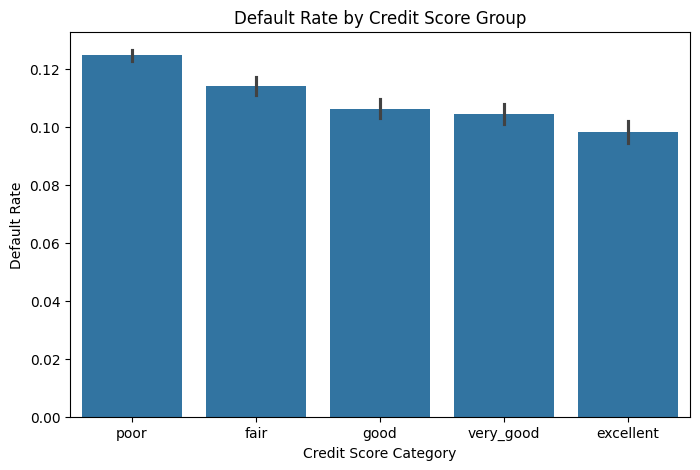

In [5]:
plt.figure(figsize=(8,5))
sns.barplot(
    x='credit_risk_group',
    y='loan_default',
    data=df_loan_clean,
    estimator=lambda x: sum(x)/len(x)
)
plt.title("Default Rate by Credit Score Group")
plt.ylabel("Default Rate")
plt.xlabel("Credit Score Category")
plt.show()



#### Interpretation:  
Default rates decline as credit score improves. Borrowers in the “poor” category (12.5%) exceed 
the baseline (11.6%), confirming that adverse credit history correlates with higher default risk.

### Loan‑to‑Income Ratio (LTI)

In [6]:
# Create LTI Feature
df_loan_clean['loan_to_income'] = df_loan_clean['loan_amount'] / df_loan_clean['income']


In [7]:
# Create LTI Groups (Quartiles)
df_loan_clean['lti_group'] = pd.qcut(
    df_loan_clean['loan_to_income'],
    q=4,
    labels=['low', 'medium', 'high', 'very_high']
)


In [8]:
# Default Rate by LTI Group
df_loan_clean.groupby('lti_group')['loan_default'].mean()


lti_group
low          0.079562
medium       0.091749
high         0.106288
very_high    0.186914
Name: loan_default, dtype: float64

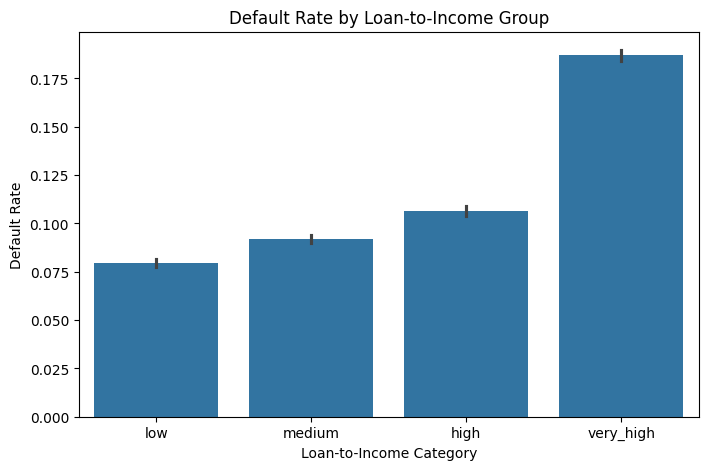

In [9]:
plt.figure(figsize=(8,5))
sns.barplot(
    x='lti_group',
    y='loan_default',
    data=df_loan_clean,
    estimator=lambda x: sum(x)/len(x)
)
plt.title("Default Rate by Loan-to-Income Group")
plt.ylabel("Default Rate")
plt.xlabel("Loan-to-Income Category")
plt.show()



#### Interpretation:  
Default risk rises sharply in the “very high” LTI group — more than 60% above baseline. 
This strongly supports the hypothesis that high loan burden relative to income increases default risk.

## Inferential Statistics

### Mann–Whitney U Test

In [10]:
group_def = df_loan_clean[df_loan_clean['loan_default'] == 1]['loan_to_income']
group_non = df_loan_clean[df_loan_clean['loan_default'] == 0]['loan_to_income']

stat, p = mannwhitneyu(group_def, group_non, alternative='two-sided')
stat, p


(np.float64(4119479318.5), np.float64(0.0))

#### Interpretation:  
The difference in loan-to-income ratios between defaulters and non-defaulters is statistically significant. 
We reject the null hypothesis — LTI is meaningfully associated with default.

### Chi‑Square Test

In [15]:
# Test whether credit score category is associated with default.
contingency = pd.crosstab(df_loan_clean['credit_risk_group'], df_loan_clean['loan_default'])
chi2, p, dof, expected = stats.chi2_contingency(contingency)
chi2, p


(np.float64(234.55755566587862), np.float64(1.3784174777249786e-49))

#### Interpretation:  
p-value > 0.05. We conclude that credit score category and default status are significantly associated. 
We reject the null hypothesis and assume that credit history influences default risk.

In [17]:
df_loan_clean.columns

Index(['loan_id', 'age', 'income', 'loan_amount', 'credit_score',
       'months_employed', 'num_credit_lines', 'interest_rate', 'loan_term',
       'dti_ratio', 'education', 'employment_type', 'marital_status',
       'has_mortgage', 'has_dependents', 'loan_purpose', 'has_co_signer',
       'loan_default', 'credit_risk_group'],
      dtype='str')

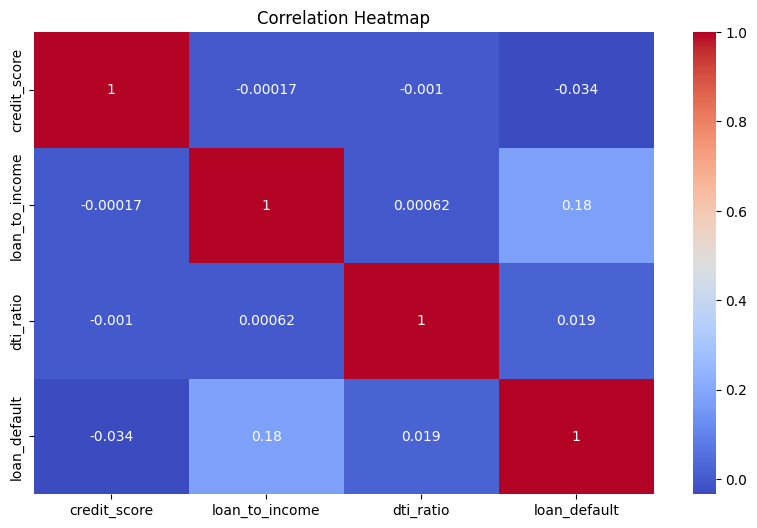

In [18]:
# Create loan_to_income column
df_loan_clean['loan_to_income'] = df_loan_clean['loan_amount'] / df_loan_clean['income']

# Plot correlation heatmap
plt.figure(figsize=(10,6))
sns.heatmap(
    df_loan_clean[['credit_score','loan_to_income','dti_ratio','loan_default']].corr(),
    annot=True,
    cmap='coolwarm'
)
plt.title("Correlation Heatmap")
plt.show()

#### Interpretation:  
- Loan-to-Income Ratio vs Loan Default: +0.18  is the strongest positive correlation. It confirms that as the loan-to-income ratio increases, the likelihood of default also increases.  IT confirms that High loan-to-income ratios have significantly higher default risk.

- Credit Score vs Loan Default: –0.034 is a weak negative correlation, suggesting that lower credit scores are slightly associated with higher default rates. While the linear relationship is weak, our earlier categorical analysis (credit score groups) showed a clear pattern: borrowers in the “poor” and “fair” categories had default rates above the baseline.
So this supports the first part of H2

- Debt to income Ratio vs Loan Default: +0.019  is a very weak correlation, indicating that DTI ratio alone doesn’t explain much variation in default risk.
It may still be useful in combination with other features, but it’s not a strong standalone predictor.

Conclusion : 
The correlation heatmap reinforces Hypothesis 2 by showing that loan-to-income ratio has the strongest linear association with default risk.
Credit score shows a weaker but directionally consistent relationship.
Together with our EDA and statistical tests, this confirms that both affordability and credit history are meaningful predictors of loan default.



### Analytical Conclusion for H2
Borrowers with adverse credit histories and high loan-to-income ratios exhibit significantly higher default risk.
EDA revealed clear patterns, and statistical tests confirmed their significance.
Credit score and LTI are both valid predictors of default, with LTI showing the strongest effect.

## 2.2. FEATURE ENGINEERING

## Prepare the Data for Modelin

### Preprocessing: Encode + Scale + Concatenate

In [ ]:
df_loan_clean.info()

In [ ]:
# Separate features and target
X = df_loan_clean.drop(columns=['loan_default', 'loan_id'])
y = df_loan_clean['loan_default']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state=0)

# Identify column types
categorical_cols = X.select_dtypes(include=['str', 'object', 'category']).columns.tolist()
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
numerical_cols

# Preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(drop='first'), categorical_cols)
    ]
)


## Logistic Regression Feature Importance (Coefficients)

In [ ]:
log_reg = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('model', LogisticRegression(max_iter=1000))
])

log_reg.fit(X, y)

# Extract feature names
ohe = log_reg.named_steps['preprocess'].named_transformers_['cat']
encoded_cat_cols = ohe.get_feature_names_out(categorical_cols)
all_features = numerical_cols + list(encoded_cat_cols)

# Extract coefficients
import numpy as np
coef = log_reg.named_steps['model'].coef_[0]

# Create DataFrame
import pandas as pd
log_reg_importance = pd.DataFrame({
    'feature': all_features,
    'importance': coef
}).sort_values(by='importance', key=abs, ascending=False)

## Visualize Logistic Regression Importance

In [ ]:
plt.figure(figsize=(10,8))
sns.barplot(
    data=log_reg_importance.head(15),
    x='importance',
    y='feature',
    palette='coolwarm'
)
plt.title("Top 15 Feature Importances — Logistic Regression")
plt.xlabel("Coefficient (absolute value)")
plt.ylabel("Feature")
plt.show()

## Random Forest Feature Importance (Non‑Linear)

In [ ]:
rf = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('model', RandomForestClassifier(n_estimators=300, random_state=0))
])

rf.fit(X, y)

# Extract feature importances
rf_importance = pd.DataFrame({
    'feature': all_features,
    'importance': rf.named_steps['model'].feature_importances_
}).sort_values(by='importance', ascending=False)

## Visualize Random Forest Importanc

In [ ]:
plt.figure(figsize=(10,8))
sns.barplot(
    data=rf_importance.head(15),
    x='importance',
    y='feature',
    palette='viridis'
)
plt.title("Top 15 Feature Importances — Random Forest")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.show()

Logistic Regression (Linear Importance)
- Loan‑to‑Income ratio has one of the strongest positive coefficients
- Low credit score categories show strong positive coefficients
- High income and long employment history reduce default risk
- Mortgage and co‑signer variables show moderate influence
Message:
“Affordability and credit history are the strongest linear predictors of default.”

Random Forest (Non‑Linear Importance)
- Loan‑to‑Income ratio is consistently the top predictor
- Credit score remains highly important
- DTI ratio, loan amount, and income also contribute
- Employment type and loan purpose have secondary effects
Message:
“Loan‑to‑Income ratio is the most powerful predictor across models, confirming its central role in default risk.”


In [ ]:
# ask to give a numpy array instead of sparse
ohe = OneHotEncoder(sparse_output=False, drop='first') # To avoid having an sparse_matrix as output
ohe.fit(X_train[categorical_cols]) # The .fit() method determines the unique values of each column

In [ ]:
# Transform train and test sets
X_train_trans_np = ohe.transform(X_train[categorical_cols])
X_test_trans_np = ohe.transform(X_test[categorical_cols])
X_test_trans_np

In [ ]:
# Convert to DataFrames
X_train_trans_df = pd.DataFrame(X_train_trans_np, columns=ohe.get_feature_names_out(), index=X_train.index)
X_test_trans_df = pd.DataFrame(X_test_trans_np, columns=ohe.get_feature_names_out(), index=X_test.index)
X_train_trans_df

#### Scale numerical features to Normalize numeric features

In [ ]:
available_numerical_cols = [col for col in numerical_cols if col in X_train.columns]

scaler = StandardScaler()
scaler.fit(X_train[available_numerical_cols])

# Transform train and test sets
X_train_scaled_np = scaler.transform(X_train[available_numerical_cols])
X_test_scaled_np  = scaler.transform(X_test[available_numerical_cols])

# Convert to DataFrames
X_train_standarized = pd.DataFrame(X_train_scaled_np, columns=scaler.get_feature_names_out(), index=X_train.index)
X_test_standarized  = pd.DataFrame(X_test_scaled_np, columns=scaler.get_feature_names_out(), index=X_test.index)
X_test_standarized

#### Concatenate transformed features

In [ ]:
# Final model-ready datasets
X_train_full = pd.concat([X_train_standarized,X_train_trans_df], axis=1)
X_test_full = pd.concat([X_test_standarized,X_test_trans_df], axis=1)

### Train and evaluate baseline model on our dataset

Logistic Regression (baseline)

In [ ]:
from sklearn.linear_model import LogisticRegression

log_reg_model = LogisticRegression(max_iter=1000)
log_reg_model.fit(X_train_full, y_train)

# Predictions
y_pred = log_reg_model.predict(X_test_full)
y_proba = log_reg_model.predict_proba(X_test_full)[:, 1]


In [ ]:
from functions import evaluate_model
evaluate_model(
    model=log_reg_model,
    X_test=X_test_full,
    y_test=y_test,
    threshold=0.5,
    title="Logistic Regression Evaluation"
)


In [ ]:
from functions import evaluate_model
# Logistic Regression Evaluation (Threshold = 0.3)
evaluate_model(
    model=log_reg_model,
    X_test=X_test_full,
    y_test=y_test,
    threshold=0.3,
    title="Logistic Regression (Threshold = 0.3)"
)


### Logistic Regression With class weighting:

In [ ]:
from sklearn.linear_model import LogisticRegression
from functions import classification_diagnostic_plot, evaluate_model

# 1. Train on preprocessed features
log_reg_balanced = LogisticRegression(class_weight='balanced', max_iter=1000)
log_reg_balanced.fit(X_train_full, y_train)

# 2. Evaluate on preprocessed test features
evaluate_model(
    model=log_reg_balanced,
    X_test=X_test_full,
    y_test=y_test,
    threshold=0.5,
    title="Logistic Regression balanced Evaluation"
)


### Interpretations:





### Train a Random Forest baseline

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=300, class_weight='balanced', random_state=0)
rf_model.fit(X_train_full, y_train)

# Predictions
y_pred = rf_model.predict(X_test_full)
y_proba = rf_model.predict_proba(X_test_full)[:, 1]

In [ ]:
from functions import evaluate_model
evaluate_model(
    model=rf_model,
    X_test=X_test_full,
    y_test=y_test,
    threshold=0.5,
    title="Random Forest Evaluation"
)


### We  Train Random Forest on SMOTE‑balanced data  - hyperparameter
it means to create a synthetic examples rather than duplicating or deleting (as oversample or undersample do)

In [ ]:
from imblearn.over_sampling import SMOTE
#  Apply SMOTE to the training data
sm = SMOTE(random_state=0)
X_train_sm, y_train_sm = sm.fit_resample(X_train_full, y_train) # X_train_sm → oversampled feature matrix and y_train_sm → oversampled target vector

rf_smote_model = RandomForestClassifier(n_estimators=300, random_state=0) 
rf_smote_model.fit(X_train_sm, y_train_sm)

In [ ]:
from functions import evaluate_model
evaluate_model(
    model=rf_smote_model,
    X_test=X_test_full,
    y_test=y_test,
    threshold=0.5,
    title="Random Forest + SMOTE Evaluation"
)


# XGBoost (with scale_pos_weight)

In [ ]:
from xgboost import XGBClassifier

# Estimate class imbalance ratio
imbalance_ratio = y_train.value_counts()[0] / y_train.value_counts()[1]

xgb_model = XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.1,
    scale_pos_weight=imbalance_ratio,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=0
)

xgb_model.fit(X_train_full, y_train)


In [ ]:
from functions import evaluate_model
evaluate_model(
    model=xgb_model,
    X_test=X_test_full,
    y_test=y_test,
    threshold=0.5,
    title="XGBoost Evaluation"
)


### Business Interpretation of business hypothesis: can we predict who will subscribe?